In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision import models
from torchsummary import summary
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold
from skorch.callbacks import EarlyStopping
from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring
from itertools import product

### 1. Loading data and normalization

In [2]:
# Set device based on availability 
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Data normalization for CIFAR-10
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

Using device: mps
Files already downloaded and verified
Files already downloaded and verified


### 2. Defining Training and Evaluation functions

In [3]:
# Train and Validate Functions
def train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=25, early_stopping_patience=3):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 * correct_train / total_train
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)

        # Validation phase
        if valloader is not None:
            model.eval()
            val_loss = 0.0
            correct_val = 0
            total_val = 0
            with torch.no_grad():
                for inputs, labels in valloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()

            val_loss /= len(valloader)
            val_acc = 100 * correct_val / total_val
            val_loss_history.append(val_loss)
            val_acc_history.append(val_acc)

            print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {epoch_acc:.2f}%, Val Acc: {val_acc:.2f}%')
        else:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%')

       # Early Stopping Check (based on validation or training loss)
        if valloader is not None:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f'Early stopping at epoch {epoch + 1}')
                    break
        else:
            # Early stopping based on training loss if no validation loader is provided
            if epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f'Early stopping at epoch {epoch + 1} due to no improvement in training loss')
                    break

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

# Creating a function to tackle different length of epochs 
def pad_sequences(sequences, max_length):
    padded_sequences = np.full((len(sequences), max_length), np.nan)  # Creating an array filled with NaN values
    for i, sequence in enumerate(sequences):
        padded_sequences[i, :len(sequence)] = sequence
    return padded_sequences

# Defining Test Evaluation Function
def test_model(model, testloader, title):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100 * correct / total
    print(f'\033[1m{title} - Test Accuracy: {test_acc:.2f}%\033[0m')

# Plot Loss and Accuracy Curves
def plot_loss_acc(train_loss, val_loss, train_acc, val_acc, title):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'{title} - Loss Curves',fontsize=9,weight='bold')
    plt.xlabel('Epochs',fontsize=8)
    plt.ylabel('Loss',fontsize=8)
    plt.legend(loc='upper right',fontsize=8)

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title(f'{title} - Accuracy Curves',fontsize=9,weight='bold')
    plt.xlabel('Epochs',fontsize=8)
    plt.ylabel('Accuracy',fontsize=8)
    plt.legend(loc='upper left',fontsize=8)
    plt.savefig(f'{title.replace(" ", "_")}_Loss_Accuracy_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

### 3. Stratified K-Fold Cross-Validation Setup

In [4]:
# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
X = trainset.data  # Images 
y = np.array(trainset.targets)  # Labels

### 4. Baseline model - ResNet-18 (Trained from scratch)

In [5]:
# Custom ResNet-18 from scratch
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)
        return out


class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 2)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride=1):
        layers = []
        layers.append(BasicBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [7]:
# Training ResNet-18 from scratch
print("Baseline Model: ResNet-18")
all_train_loss = []
all_val_loss = []
all_train_acc = []
all_val_acc = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    # Getting training and validation splits
    train_subset = Subset(trainset, train_idx)
    val_subset = Subset(trainset, val_idx)

    # Data loaders for training and validation
    trainloader = DataLoader(train_subset, batch_size=32, shuffle=True)
    valloader = DataLoader(val_subset, batch_size=32, shuffle=False)

    # Initialize model (Custom ResNet-18) and move to device
    model = ResNet18(num_classes=10)
    model.to(device)

    # Loss and optimizer (initialize inside the loop for each fold)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Training the model on this fold with early stopping
    train_loss, val_loss, train_acc, val_acc = train_model(model, trainloader, valloader, criterion,
                                                           optimizer, early_stopping_patience=3)

    # Storing metrics for all folds
    all_train_loss.append(train_loss)
    all_val_loss.append(val_loss)
    all_train_acc.append(train_acc)
    all_val_acc.append(val_acc)

# Finding the maximum length among all folds
max_train_length = max(len(x) for x in all_train_loss)
max_val_length = max(len(x) for x in all_val_loss)

# Padding all sequences to have the same length
padded_train_loss = pad_sequences(all_train_loss, max_train_length)
padded_val_loss = pad_sequences(all_val_loss, max_val_length)
padded_train_acc = pad_sequences(all_train_acc, max_train_length)
padded_val_acc = pad_sequences(all_val_acc, max_val_length)

# Calculating average metrics across all folds, ignoring NaN values
avg_train_loss = np.nanmean(padded_train_loss, axis=0)
avg_val_loss = np.nanmean(padded_val_loss, axis=0)
avg_train_acc = np.nanmean(padded_train_acc, axis=0)
avg_val_acc = np.nanmean(padded_val_acc, axis=0)

Baseline Model: ResNet-18
Epoch [1/25], Train Loss: 1.5227, Val Loss: 1.2704, Train Acc: 45.00%, Val Acc: 53.96%
Epoch [2/25], Train Loss: 1.1460, Val Loss: 1.1234, Train Acc: 58.99%, Val Acc: 59.72%
Epoch [3/25], Train Loss: 0.9396, Val Loss: 1.0411, Train Acc: 66.59%, Val Acc: 63.32%
Epoch [4/25], Train Loss: 0.7742, Val Loss: 0.9993, Train Acc: 72.77%, Val Acc: 65.22%
Epoch [5/25], Train Loss: 0.6333, Val Loss: 1.0133, Train Acc: 77.67%, Val Acc: 65.81%
Epoch [6/25], Train Loss: 0.4898, Val Loss: 1.0815, Train Acc: 82.90%, Val Acc: 66.23%
Epoch [7/25], Train Loss: 0.3806, Val Loss: 1.0993, Train Acc: 86.76%, Val Acc: 66.66%
Early stopping at epoch 7
Epoch [1/25], Train Loss: 1.5294, Val Loss: 1.2741, Train Acc: 44.84%, Val Acc: 54.00%
Epoch [2/25], Train Loss: 1.1578, Val Loss: 1.1394, Train Acc: 58.57%, Val Acc: 60.14%
Epoch [3/25], Train Loss: 0.9501, Val Loss: 1.0354, Train Acc: 66.35%, Val Acc: 63.36%
Epoch [4/25], Train Loss: 0.7875, Val Loss: 1.0135, Train Acc: 72.18%, Val Acc

Average Validation Accuracy Across Folds for the Baseline: 63.44%


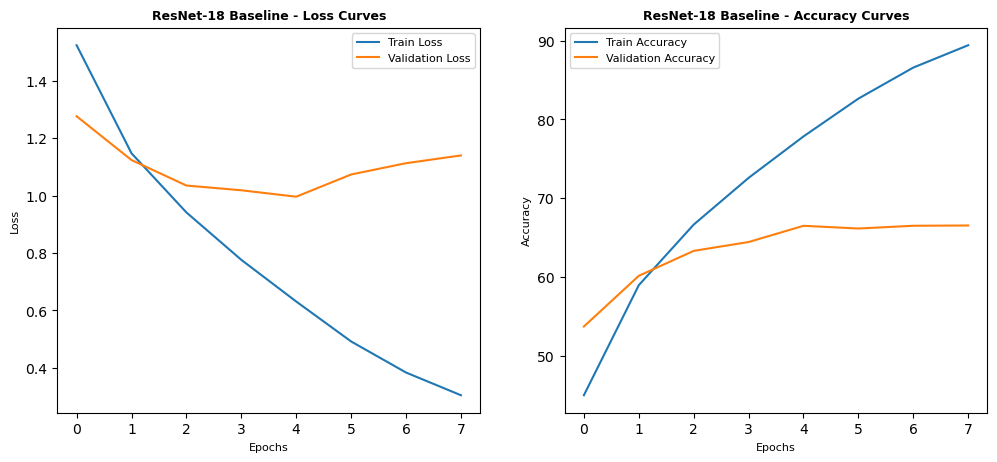

In [8]:
# Print average metrics
print(f"\033[1mAverage Validation Accuracy Across Folds for the Baseline: {np.nanmean(avg_val_acc):.2f}%\033[0m")

# Plot average training/validation loss and accuracy curves
plot_loss_acc(avg_train_loss, avg_val_loss, avg_train_acc, avg_val_acc, title="ResNet-18 Baseline")

##### The baseline model appears to be overfitting, as indicated by the divergence between training and validation loss and accuracy curves.

### 5. Hyperparameter optimization

In [6]:
print("Hyperparameter Optimization: ResNet-18")

# Defining the hyperparameter grid
param_grid = {
    'lr': [0.0001, 0.001],
    'optimizer': [optim.Adam, optim.NAdam],
    'batch_size': [32, 64],
    'weight_decay': [0.0001, 0.001]  # Adding weight decay for regularization
}

# Initialize lists to store metrics for each hyperparameter combination
all_combinations_metrics = []

# Iterating over all combinations of hyperparameters
for lr, optimizer_class, batch_size, weight_decay in product(param_grid['lr'], param_grid['optimizer'], param_grid['batch_size'], param_grid['weight_decay']):
    print(f"\033[1mTraining with lr={lr}, optimizer={optimizer_class.__name__}, batch_size={batch_size}, weight_decay={weight_decay}\033[0m")
    
    all_train_loss = []
    all_val_loss = []
    all_train_acc = []
    all_val_acc = []

    # Initialize model 
    model = ResNet18(num_classes=10)
    initial_state = model.state_dict()

    # Cross-validation loop
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"Fold {fold + 1}/{skf.n_splits}")

        # Reset model weights before each fold
        model.load_state_dict(initial_state)
        model.to(device)

        # Get training and validation splits
        train_subset = Subset(trainset, train_idx)
        val_subset = Subset(trainset, val_idx)

        # Data loaders for training and validation
        trainloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        valloader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optimizer_class(model.parameters(), lr=lr, weight_decay=weight_decay)

        # Train the model on this fold with early stopping
        train_loss, val_loss, train_acc, val_acc = train_model(
            model, trainloader, valloader, criterion,
            optimizer, num_epochs=15, early_stopping_patience=3
        )

        # Store metrics for all folds
        all_train_loss.append(train_loss)
        all_val_loss.append(val_loss)
        all_train_acc.append(train_acc)
        all_val_acc.append(val_acc)

    # Finding the maximum length among all folds for consistency
    max_length = max(max(len(x) for x in all_train_loss), max(len(x) for x in all_val_loss))

    # Padding all sequences to have the same length
    padded_train_loss = pad_sequences(all_train_loss, max_length)
    padded_val_loss = pad_sequences(all_val_loss, max_length)
    padded_train_acc = pad_sequences(all_train_acc, max_length)
    padded_val_acc = pad_sequences(all_val_acc, max_length)

    # Calculating average metrics across all folds, ignoring NaN values
    avg_train_loss = np.nanmean(padded_train_loss, axis=0)
    avg_val_loss = np.nanmean(padded_val_loss, axis=0)
    avg_train_acc = np.nanmean(padded_train_acc, axis=0)
    avg_val_acc = np.nanmean(padded_val_acc, axis=0)

    # Store metrics for this hyperparameter combination
    all_combinations_metrics.append({
        'params': {
            'lr': lr,
            'optimizer': optimizer_class.__name__,
            'batch_size': batch_size,
            'weight_decay': weight_decay
        },
        'avg_train_loss': avg_train_loss,
        'avg_val_loss': avg_val_loss,
        'avg_train_acc': avg_train_acc,
        'avg_val_acc': avg_val_acc
    })

Hyperparameter Optimization: ResNet-18
Training with lr=0.0001, optimizer=Adam, batch_size=32, weight_decay=0.0001
Fold 1/3
Epoch [1/15], Train Loss: 1.5068, Val Loss: 1.2728, Train Acc: 45.84%, Val Acc: 54.53%
Epoch [2/15], Train Loss: 1.1333, Val Loss: 1.1265, Train Acc: 59.64%, Val Acc: 59.91%
Epoch [3/15], Train Loss: 0.9337, Val Loss: 1.0358, Train Acc: 67.04%, Val Acc: 63.62%
Epoch [4/15], Train Loss: 0.7728, Val Loss: 0.9784, Train Acc: 72.80%, Val Acc: 66.00%
Epoch [5/15], Train Loss: 0.6282, Val Loss: 1.0138, Train Acc: 77.91%, Val Acc: 65.43%
Epoch [6/15], Train Loss: 0.4953, Val Loss: 1.0654, Train Acc: 82.63%, Val Acc: 66.47%
Epoch [7/15], Train Loss: 0.3918, Val Loss: 1.0936, Train Acc: 86.38%, Val Acc: 66.57%
Early stopping at epoch 7
Fold 2/3
Epoch [1/15], Train Loss: 1.5305, Val Loss: 1.2508, Train Acc: 45.13%, Val Acc: 54.72%
Epoch [2/15], Train Loss: 1.1537, Val Loss: 1.1096, Train Acc: 59.00%, Val Acc: 60.75%
Epoch [3/15], Train Loss: 0.9481, Val Loss: 1.0394, Train 

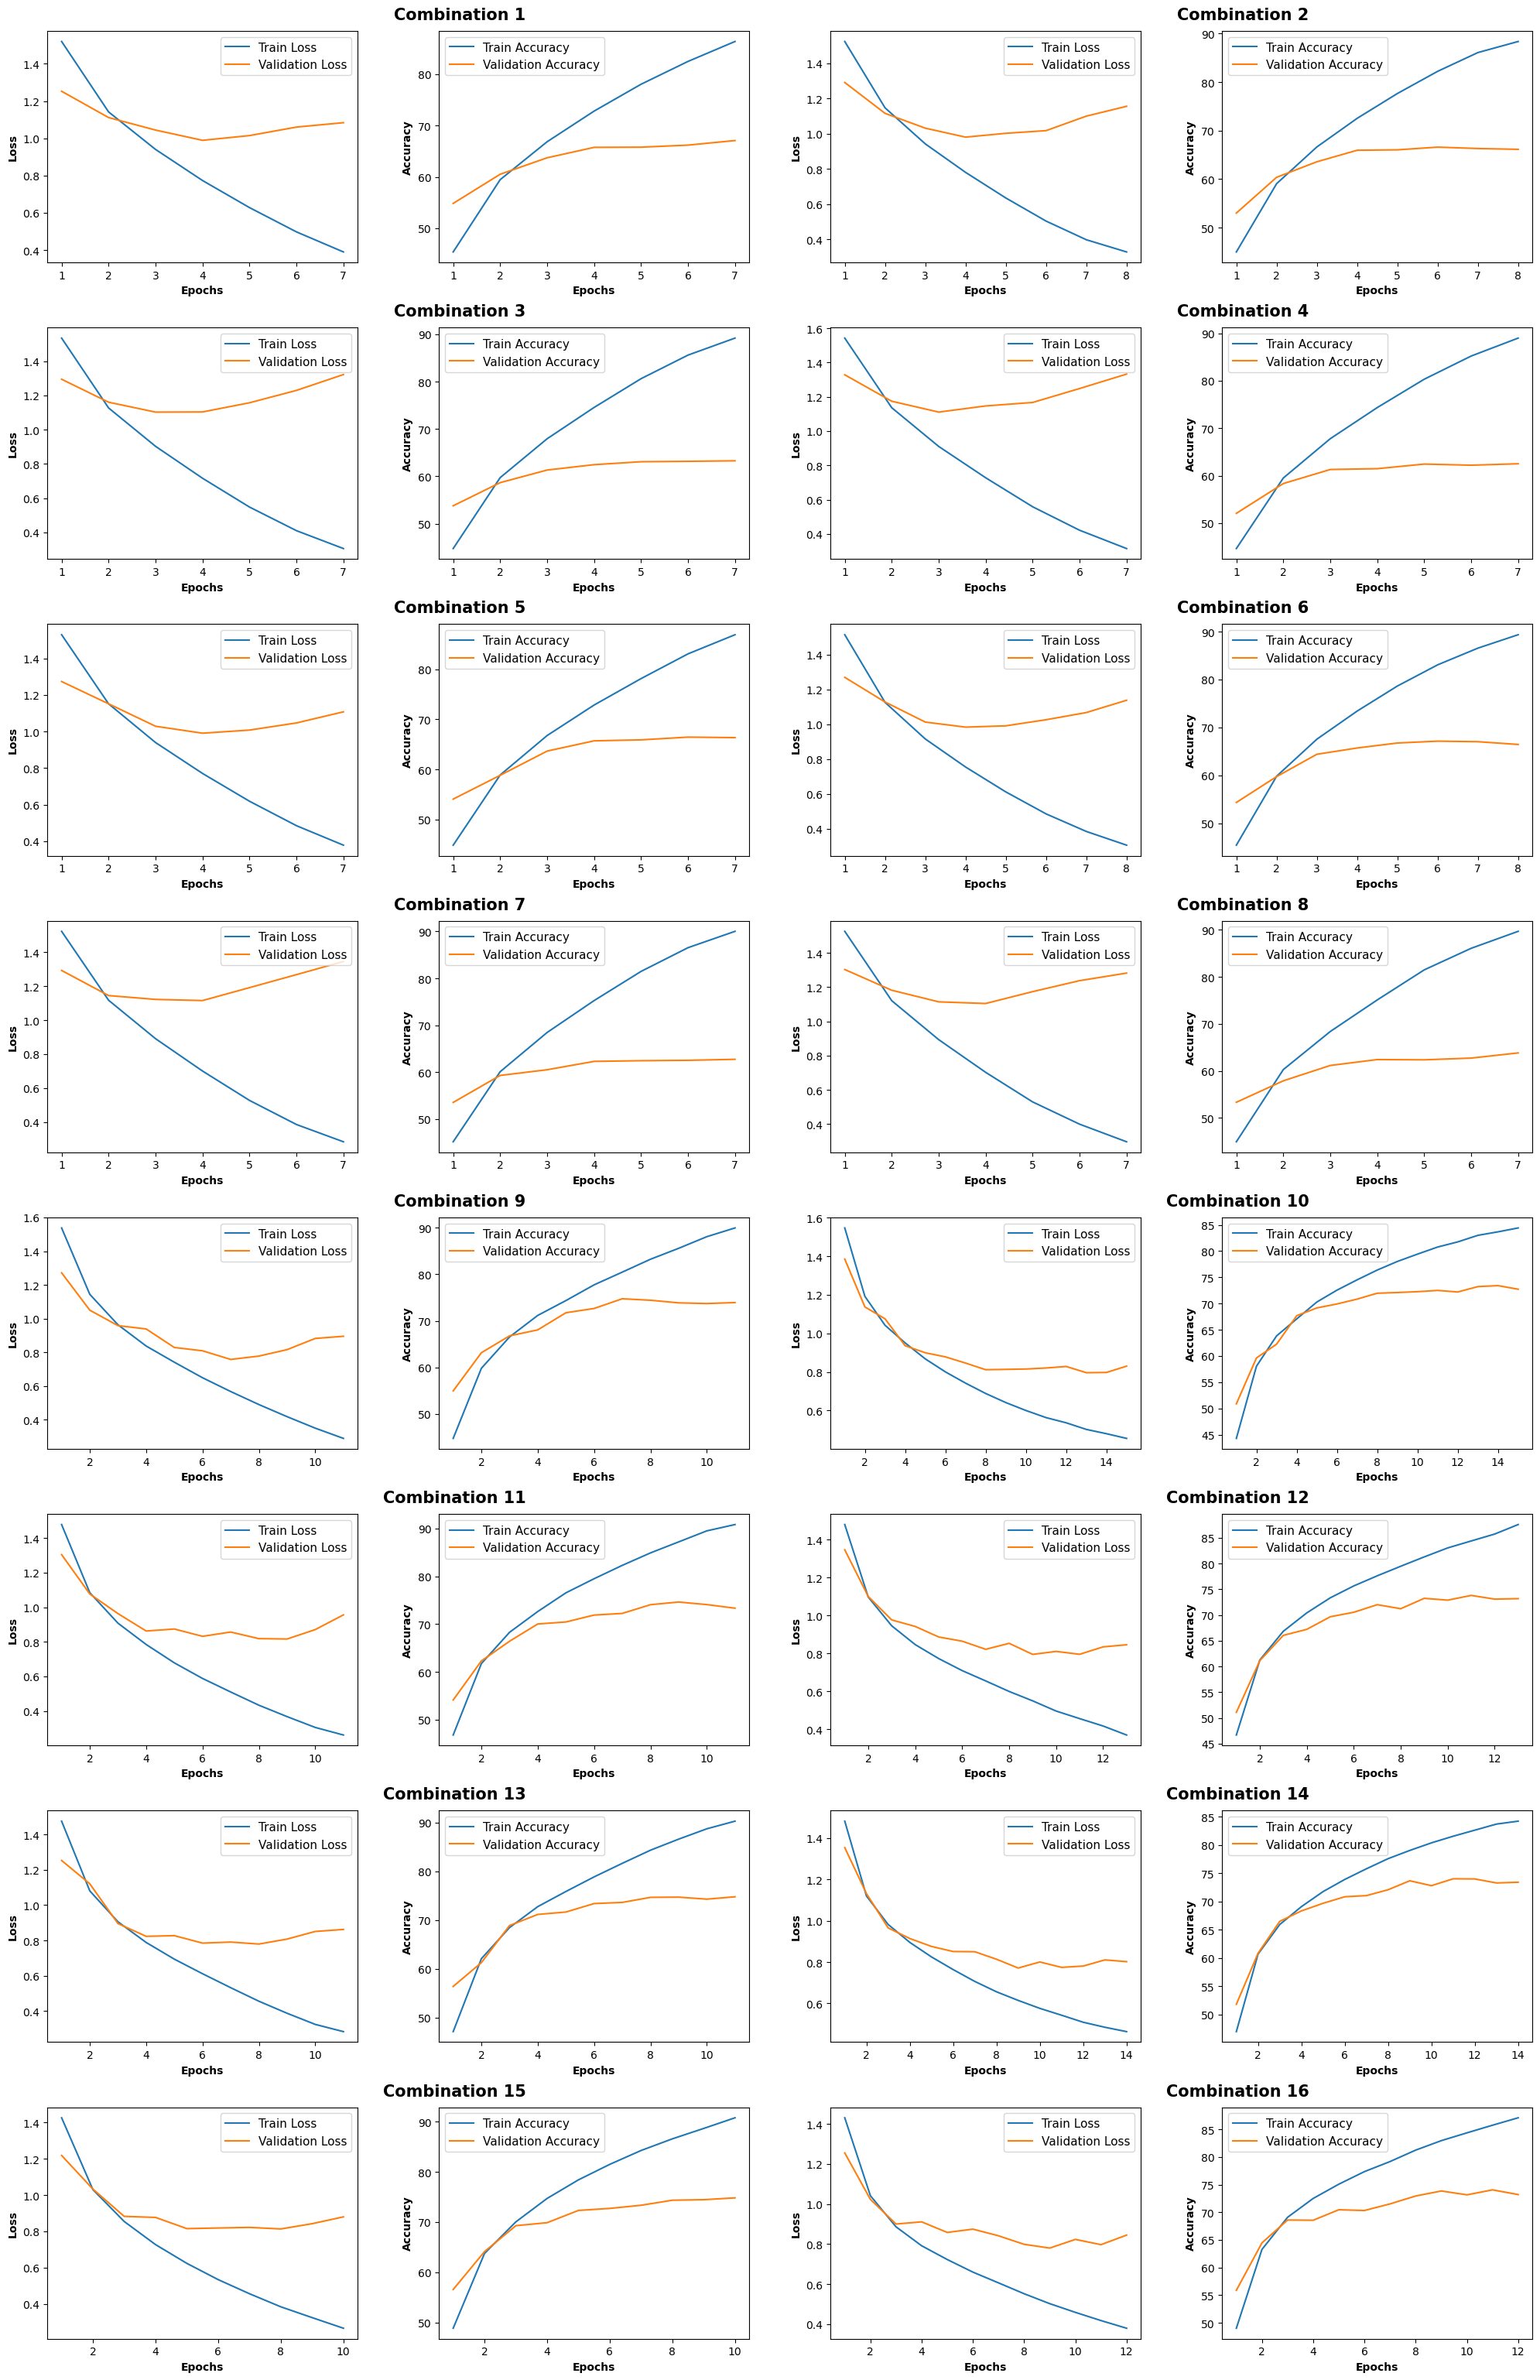

In [7]:
# Plotting metrics for each combination
plt.figure(figsize=(20, len(all_combinations_metrics) * 2))

# Iterate over each combination and plot metrics
for idx, metrics in enumerate(all_combinations_metrics):
    params = metrics['params']
    train_loss = metrics['avg_train_loss']
    val_loss = metrics['avg_val_loss']
    train_acc = metrics['avg_train_acc']
    val_acc = metrics['avg_val_acc']

    row = idx // 2
    col_offset = (idx % 2) * 2

    # Plotting Training and Validation Loss for each combination
    plt.subplot(len(all_combinations_metrics) // 2 + len(all_combinations_metrics) % 2, 4, 4 * row + col_offset + 1)
    plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss')
    plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
    plt.xlabel('Epochs',fontsize=10,weight='bold')
    plt.ylabel('Loss',fontsize=10,weight='bold')
    plt.legend(loc='upper right',fontsize=11)

    # Plotting Training and Validation Accuracy for each combination
    plt.subplot(len(all_combinations_metrics) // 2 + len(all_combinations_metrics) % 2, 4, 4 * row + col_offset + 2)
    plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train Accuracy')
    plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs',fontsize=10,weight='bold')
    plt.ylabel('Accuracy',fontsize=10,weight='bold'),
    plt.legend(loc='upper left',fontsize=11)
    plt.text(x=0.28, y=1.05, s=f'Combination {idx + 1}', fontsize=15,weight='bold', ha='right', transform=plt.gca().transAxes)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig('hyperparameters.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
# Finding the best hyperparameters based on lowest average validation loss 
best_model_hyperparameterphase = min(all_combinations_metrics, key=lambda x: np.mean(x['avg_val_loss']))
print("Best Hyperparameters:", best_model_hyperparameterphase['params'])
print(f"Best Average Validation Accuracy: {np.mean(best_model_hyperparameterphase['avg_val_acc']):.2f}%")

Best Hyperparameters: {'lr': 0.001, 'optimizer': 'NAdam', 'batch_size': 32, 'weight_decay': 0.0001}
Best Average Validation Accuracy: 70.44%


##### We can use the best hyperparameter settings for the next set of experiments, trying to make further improvements.

### 6. Experimenting with dropout and weight decay

#### 6.1 Experimenting with dropout value of 0.3 and weight decay

In [4]:
# Custom ResNet-18 from scratch with Dropout
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout=0.3):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=dropout)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)
        return out


class ResNet18(nn.Module):
    def __init__(self, num_classes=10, dropout=0.3):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 2, dropout=dropout)
        self.layer2 = self._make_layer(128, 2, stride=2, dropout=dropout)
        self.layer3 = self._make_layer(256, 2, stride=2, dropout=dropout)
        self.layer4 = self._make_layer(512, 2, stride=2, dropout=dropout)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride=1, dropout=0.3):
        layers = []
        layers.append(BasicBlock(self.in_channels, out_channels, stride, dropout))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels, dropout=dropout))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [6]:
# Using the best hyperparameters selected earlier
best_lr = 0.001  
best_batch_size = 32  
best_weight_decay = 0.0001  

print(f"Experimenting with Dropout=0.3 and Weight Decay={best_weight_decay}")

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
X = trainset.data  # Images
y = np.array(trainset.targets)  # Labels

all_train_loss = []
all_val_loss = []
all_train_acc = []
all_val_acc = []

# Initialize model 
model = ResNet18(num_classes=10, dropout=0.3)
initial_state = model.state_dict()

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}/{skf.n_splits}")

    # Reset model weights before each fold
    model.load_state_dict(initial_state)
    model.to(device)

    # Get training and validation splits
    train_subset = Subset(trainset, train_idx)
    val_subset = Subset(trainset, val_idx)

    # Data loaders for training and validation
    trainloader = DataLoader(train_subset, batch_size=best_batch_size, shuffle=True)
    valloader = DataLoader(val_subset, batch_size=best_batch_size, shuffle=False)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.NAdam(model.parameters(), lr=best_lr, weight_decay=best_weight_decay)

    # Train the model on this fold with early stopping
    train_loss, val_loss, train_acc, val_acc = train_model(
        model, trainloader, valloader, criterion,
        optimizer, num_epochs=25, early_stopping_patience=3
    )

    # Store metrics for all folds
    all_train_loss.append(train_loss)
    all_val_loss.append(val_loss)
    all_train_acc.append(train_acc)
    all_val_acc.append(val_acc)

# Finding the maximum length among all folds for consistency
max_length = max(max(len(x) for x in all_train_loss), max(len(x) for x in all_val_loss))

# Padding all sequences to have the same length
padded_train_loss = pad_sequences(all_train_loss, max_length)
padded_val_loss = pad_sequences(all_val_loss, max_length)
padded_train_acc = pad_sequences(all_train_acc, max_length)
padded_val_acc = pad_sequences(all_val_acc, max_length)

# Calculating average metrics across all folds, ignoring NaN values
avg_train_loss = np.nanmean(padded_train_loss, axis=0)
avg_val_loss = np.nanmean(padded_val_loss, axis=0)
avg_train_acc = np.nanmean(padded_train_acc, axis=0)
avg_val_acc = np.nanmean(padded_val_acc, axis=0)

Experimenting with Dropout=0.3 and Weight Decay=0.0001
Fold 1/3
Epoch [1/25], Train Loss: 1.5748, Val Loss: 1.3884, Train Acc: 43.14%, Val Acc: 50.64%
Epoch [2/25], Train Loss: 1.1923, Val Loss: 1.0751, Train Acc: 57.88%, Val Acc: 62.09%
Epoch [3/25], Train Loss: 1.0239, Val Loss: 0.9428, Train Acc: 64.36%, Val Acc: 66.72%
Epoch [4/25], Train Loss: 0.9262, Val Loss: 0.9385, Train Acc: 67.85%, Val Acc: 66.97%
Epoch [5/25], Train Loss: 0.8392, Val Loss: 0.8256, Train Acc: 70.73%, Val Acc: 71.69%
Epoch [6/25], Train Loss: 0.7713, Val Loss: 0.7781, Train Acc: 73.26%, Val Acc: 72.74%
Epoch [7/25], Train Loss: 0.7128, Val Loss: 0.7387, Train Acc: 75.58%, Val Acc: 74.03%
Epoch [8/25], Train Loss: 0.6524, Val Loss: 0.7501, Train Acc: 77.32%, Val Acc: 74.33%
Epoch [9/25], Train Loss: 0.6027, Val Loss: 0.7309, Train Acc: 79.15%, Val Acc: 75.03%
Epoch [10/25], Train Loss: 0.5541, Val Loss: 0.7427, Train Acc: 80.83%, Val Acc: 74.45%
Epoch [11/25], Train Loss: 0.5138, Val Loss: 0.7167, Train Acc: 8

Average Validation Accuracy for the ResNet-18 with dropout(0.3) & weight decay : 72.08%


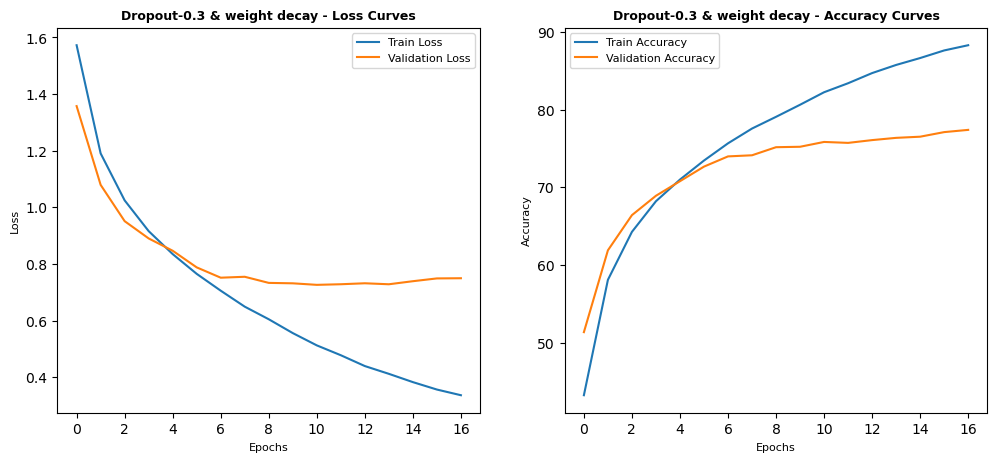

In [7]:
# Print average metrics
print(f"\033[1mAverage Validation Accuracy for the ResNet-18 with dropout(0.3) & weight decay : {np.nanmean(avg_val_acc):.2f}%\033[0m")

# Plot average training/validation loss and accuracy curves
plot_loss_acc(avg_train_loss, avg_val_loss, avg_train_acc, avg_val_acc, title="Dropout-0.3 & weight decay")

#### 6.2 Experimenting with dropout value of 0.4 and weight decay

In [8]:
# Using the best hyperparameters selected earlier
best_lr = 0.001  
best_batch_size = 32  
best_weight_decay = 0.0001  

print(f"Experimenting with Dropout=0.4 and Weight Decay={best_weight_decay}")

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
X = trainset.data  # Images
y = np.array(trainset.targets)  # Labels

all_train_loss = []
all_val_loss = []
all_train_acc = []
all_val_acc = []

# Initialize model 
model = ResNet18(num_classes=10, dropout=0.4)
initial_state = model.state_dict()

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}/{skf.n_splits}")

    # Reset model weights before each fold
    model.load_state_dict(initial_state)
    model.to(device)

    # Get training and validation splits
    train_subset = Subset(trainset, train_idx)
    val_subset = Subset(trainset, val_idx)

    # Data loaders for training and validation
    trainloader = DataLoader(train_subset, batch_size=best_batch_size, shuffle=True)
    valloader = DataLoader(val_subset, batch_size=best_batch_size, shuffle=False)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.NAdam(model.parameters(), lr=best_lr, weight_decay=best_weight_decay)

    # Train the model on this fold with early stopping
    train_loss, val_loss, train_acc, val_acc = train_model(
        model, trainloader, valloader, criterion,
        optimizer, num_epochs=25, early_stopping_patience=3
    )

    # Store metrics for all folds
    all_train_loss.append(train_loss)
    all_val_loss.append(val_loss)
    all_train_acc.append(train_acc)
    all_val_acc.append(val_acc)

# Finding the maximum length among all folds for consistency
max_length = max(max(len(x) for x in all_train_loss), max(len(x) for x in all_val_loss))

# Padding all sequences to have the same length
padded_train_loss = pad_sequences(all_train_loss, max_length)
padded_val_loss = pad_sequences(all_val_loss, max_length)
padded_train_acc = pad_sequences(all_train_acc, max_length)
padded_val_acc = pad_sequences(all_val_acc, max_length)

# Calculating average metrics across all folds, ignoring NaN values
avg_train_loss = np.nanmean(padded_train_loss, axis=0)
avg_val_loss = np.nanmean(padded_val_loss, axis=0)
avg_train_acc = np.nanmean(padded_train_acc, axis=0)
avg_val_acc = np.nanmean(padded_val_acc, axis=0)

Experimenting with Dropout=0.4 and Weight Decay=0.0001
Fold 1/3
Epoch [1/25], Train Loss: 1.5940, Val Loss: 1.3144, Train Acc: 41.99%, Val Acc: 52.97%
Epoch [2/25], Train Loss: 1.2327, Val Loss: 1.1158, Train Acc: 56.12%, Val Acc: 60.71%
Epoch [3/25], Train Loss: 1.0623, Val Loss: 1.0088, Train Acc: 62.55%, Val Acc: 64.52%
Epoch [4/25], Train Loss: 0.9576, Val Loss: 0.9402, Train Acc: 66.59%, Val Acc: 66.54%
Epoch [5/25], Train Loss: 0.8881, Val Loss: 0.8369, Train Acc: 68.95%, Val Acc: 70.86%
Epoch [6/25], Train Loss: 0.8128, Val Loss: 0.7859, Train Acc: 71.82%, Val Acc: 72.72%
Epoch [7/25], Train Loss: 0.7632, Val Loss: 0.7660, Train Acc: 73.62%, Val Acc: 73.31%
Epoch [8/25], Train Loss: 0.7143, Val Loss: 0.7492, Train Acc: 75.18%, Val Acc: 73.57%
Epoch [9/25], Train Loss: 0.6664, Val Loss: 0.7323, Train Acc: 77.00%, Val Acc: 74.45%
Epoch [10/25], Train Loss: 0.6247, Val Loss: 0.7255, Train Acc: 78.18%, Val Acc: 75.25%
Epoch [11/25], Train Loss: 0.5882, Val Loss: 0.7215, Train Acc: 7

Average Validation Accuracy for the ResNet-18 with dropout(0.4) & weight decay : 72.19%


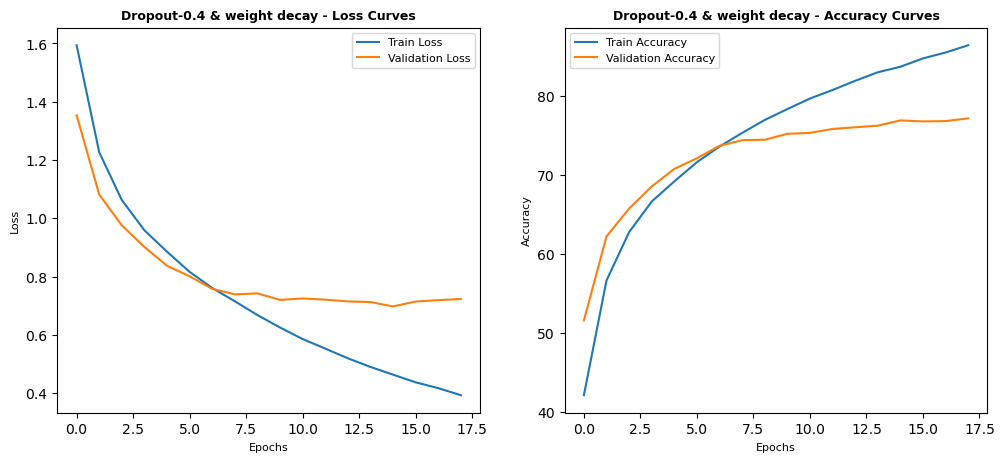

In [9]:
# Print average metrics
print(f"\033[1mAverage Validation Accuracy for the ResNet-18 with dropout(0.4) & weight decay : {np.nanmean(avg_val_acc):.2f}%\033[0m")

# Plot average training/validation loss and accuracy curves
plot_loss_acc(avg_train_loss, avg_val_loss, avg_train_acc, avg_val_acc, title="Dropout-0.4 & weight decay")

#### 6.3 Experimenting with dropout value of 0.5 and weight decay

In [5]:
# Using the best hyperparameters selected earlier
best_lr = 0.001  
best_batch_size = 32  
best_weight_decay = 0.0001  

print(f"Experimenting with Dropout=0.5 and Weight Decay={best_weight_decay}")

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
X = trainset.data  # Images
y = np.array(trainset.targets)  # Labels

all_train_loss = []
all_val_loss = []
all_train_acc = []
all_val_acc = []

# Initialize model 
model = ResNet18(num_classes=10, dropout=0.5)
initial_state = model.state_dict()

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}/{skf.n_splits}")

    # Reset model weights before each fold
    model.load_state_dict(initial_state)
    model.to(device)

    # Get training and validation splits
    train_subset = Subset(trainset, train_idx)
    val_subset = Subset(trainset, val_idx)

    # Data loaders for training and validation
    trainloader = DataLoader(train_subset, batch_size=best_batch_size, shuffle=True)
    valloader = DataLoader(val_subset, batch_size=best_batch_size, shuffle=False)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.NAdam(model.parameters(), lr=best_lr, weight_decay=best_weight_decay)

    # Train the model on this fold with early stopping
    train_loss, val_loss, train_acc, val_acc = train_model(
        model, trainloader, valloader, criterion,
        optimizer, num_epochs=25, early_stopping_patience=3
    )

    # Store metrics for all folds
    all_train_loss.append(train_loss)
    all_val_loss.append(val_loss)
    all_train_acc.append(train_acc)
    all_val_acc.append(val_acc)

# Finding the maximum length among all folds for consistency
max_length = max(max(len(x) for x in all_train_loss), max(len(x) for x in all_val_loss))

# Padding all sequences to have the same length
padded_train_loss = pad_sequences(all_train_loss, max_length)
padded_val_loss = pad_sequences(all_val_loss, max_length)
padded_train_acc = pad_sequences(all_train_acc, max_length)
padded_val_acc = pad_sequences(all_val_acc, max_length)

# Calculating average metrics across all folds, ignoring NaN values
avg_train_loss = np.nanmean(padded_train_loss, axis=0)
avg_val_loss = np.nanmean(padded_val_loss, axis=0)
avg_train_acc = np.nanmean(padded_train_acc, axis=0)
avg_val_acc = np.nanmean(padded_val_acc, axis=0)

Experimenting with Dropout=0.5 and Weight Decay=0.0001
Fold 1/3
Epoch [1/25], Train Loss: 1.6396, Val Loss: 1.3687, Train Acc: 39.93%, Val Acc: 50.39%
Epoch [2/25], Train Loss: 1.2919, Val Loss: 1.1374, Train Acc: 53.74%, Val Acc: 59.40%
Epoch [3/25], Train Loss: 1.1205, Val Loss: 0.9842, Train Acc: 60.39%, Val Acc: 65.26%
Epoch [4/25], Train Loss: 1.0193, Val Loss: 0.9272, Train Acc: 64.21%, Val Acc: 66.91%
Epoch [5/25], Train Loss: 0.9385, Val Loss: 0.8707, Train Acc: 67.25%, Val Acc: 69.53%
Epoch [6/25], Train Loss: 0.8782, Val Loss: 0.8049, Train Acc: 69.47%, Val Acc: 71.64%
Epoch [7/25], Train Loss: 0.8295, Val Loss: 0.7927, Train Acc: 71.20%, Val Acc: 72.11%
Epoch [8/25], Train Loss: 0.7740, Val Loss: 0.7762, Train Acc: 73.10%, Val Acc: 72.42%
Epoch [9/25], Train Loss: 0.7432, Val Loss: 0.7474, Train Acc: 74.24%, Val Acc: 73.74%
Epoch [10/25], Train Loss: 0.7015, Val Loss: 0.7106, Train Acc: 75.83%, Val Acc: 75.23%
Epoch [11/25], Train Loss: 0.6704, Val Loss: 0.7197, Train Acc: 7

Average Validation Accuracy for the ResNet-18 with dropout(0.5) & weight decay : 70.92%


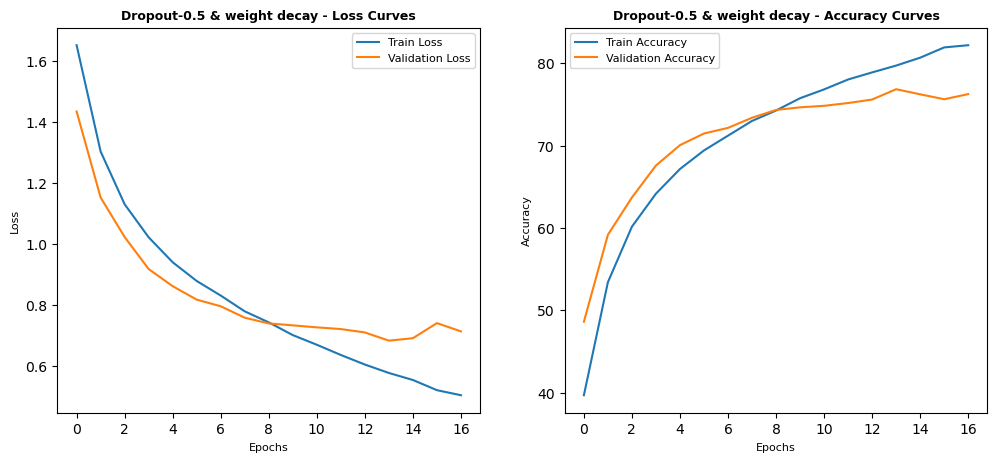

In [6]:
# Print average metrics
print(f"\033[1mAverage Validation Accuracy for the ResNet-18 with dropout(0.5) & weight decay : {np.nanmean(avg_val_acc):.2f}%\033[0m")

# Plot average training/validation loss and accuracy curves
plot_loss_acc(avg_train_loss, avg_val_loss, avg_train_acc, avg_val_acc, title="Dropout-0.5 & weight decay")

#### 6.4 Experimenting with using only the dropout value of 0.4

In [5]:
# Using the best hyperparameters selected earlier
best_lr = 0.001  
best_batch_size = 32   

print(f"Experimenting with Dropout=0.4")

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
X = trainset.data  # Images
y = np.array(trainset.targets)  # Labels

all_train_loss = []
all_val_loss = []
all_train_acc = []
all_val_acc = []

# Initialize model 
model = ResNet18(num_classes=10, dropout=0.4)
initial_state = model.state_dict()

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}/{skf.n_splits}")

    # Reset model weights before each fold
    model.load_state_dict(initial_state)
    model.to(device)

    # Get training and validation splits
    train_subset = Subset(trainset, train_idx)
    val_subset = Subset(trainset, val_idx)

    # Data loaders for training and validation
    trainloader = DataLoader(train_subset, batch_size=best_batch_size, shuffle=True)
    valloader = DataLoader(val_subset, batch_size=best_batch_size, shuffle=False)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.NAdam(model.parameters(), lr=best_lr)

    # Train the model on this fold with early stopping
    train_loss, val_loss, train_acc, val_acc = train_model(
        model, trainloader, valloader, criterion,
        optimizer, num_epochs=25, early_stopping_patience=3
    )

    # Store metrics for all folds
    all_train_loss.append(train_loss)
    all_val_loss.append(val_loss)
    all_train_acc.append(train_acc)
    all_val_acc.append(val_acc)

# Finding the maximum length among all folds for consistency
max_length = max(max(len(x) for x in all_train_loss), max(len(x) for x in all_val_loss))

# Padding all sequences to have the same length
padded_train_loss = pad_sequences(all_train_loss, max_length)
padded_val_loss = pad_sequences(all_val_loss, max_length)
padded_train_acc = pad_sequences(all_train_acc, max_length)
padded_val_acc = pad_sequences(all_val_acc, max_length)

# Calculating average metrics across all folds, ignoring NaN values
avg_train_loss = np.nanmean(padded_train_loss, axis=0)
avg_val_loss = np.nanmean(padded_val_loss, axis=0)
avg_train_acc = np.nanmean(padded_train_acc, axis=0)
avg_val_acc = np.nanmean(padded_val_acc, axis=0)

Experimenting with Dropout=0.4
Fold 1/3
Epoch [1/25], Train Loss: 1.5893, Val Loss: 1.4485, Train Acc: 42.31%, Val Acc: 49.42%
Epoch [2/25], Train Loss: 1.2182, Val Loss: 1.1039, Train Acc: 56.85%, Val Acc: 61.09%
Epoch [3/25], Train Loss: 1.0504, Val Loss: 0.9868, Train Acc: 63.14%, Val Acc: 65.75%
Epoch [4/25], Train Loss: 0.9439, Val Loss: 0.9358, Train Acc: 67.18%, Val Acc: 67.42%
Epoch [5/25], Train Loss: 0.8583, Val Loss: 0.8312, Train Acc: 70.17%, Val Acc: 71.24%
Epoch [6/25], Train Loss: 0.7824, Val Loss: 0.7618, Train Acc: 72.60%, Val Acc: 72.91%
Epoch [7/25], Train Loss: 0.7216, Val Loss: 0.7872, Train Acc: 75.01%, Val Acc: 72.34%
Epoch [8/25], Train Loss: 0.6656, Val Loss: 0.7109, Train Acc: 76.84%, Val Acc: 75.39%
Epoch [9/25], Train Loss: 0.6140, Val Loss: 0.7247, Train Acc: 78.74%, Val Acc: 75.32%
Epoch [10/25], Train Loss: 0.5687, Val Loss: 0.6955, Train Acc: 80.43%, Val Acc: 76.11%
Epoch [11/25], Train Loss: 0.5211, Val Loss: 0.6916, Train Acc: 81.87%, Val Acc: 76.71%
E

Average Validation Accuracy for the ResNet-18 with dropout(0.4): 71.99%


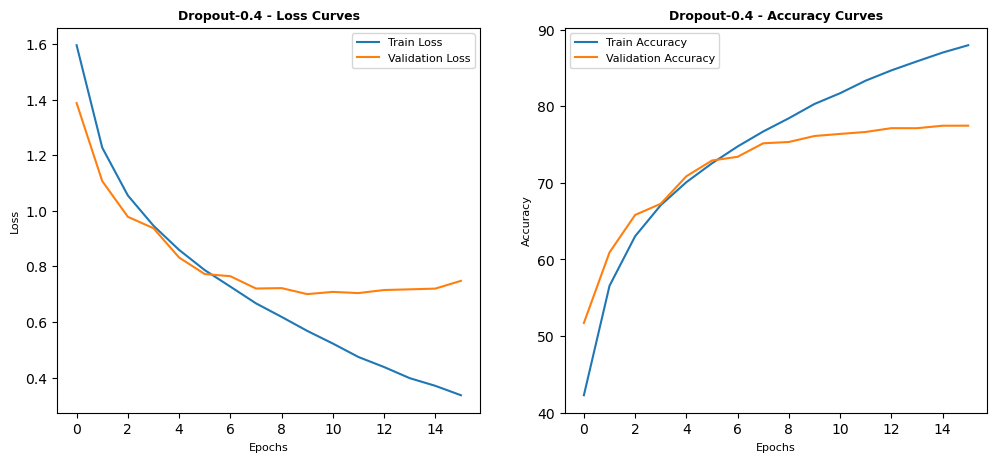

In [6]:
# Print average metrics
print(f"\033[1mAverage Validation Accuracy for the ResNet-18 with dropout(0.4): {np.nanmean(avg_val_acc):.2f}%\033[0m")

# Plot average training/validation loss and accuracy curves
plot_loss_acc(avg_train_loss, avg_val_loss, avg_train_acc, avg_val_acc, title="Dropout-0.4")

### 7. Experimenting with Data augmentation techniques

In [4]:
# Custom ResNet-18 from scratch with Dropout
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout=0.4):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=dropout)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)
        return out


class ResNet18(nn.Module):
    def __init__(self, num_classes=10, dropout=0.4):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 2, dropout=dropout)
        self.layer2 = self._make_layer(128, 2, stride=2, dropout=dropout)
        self.layer3 = self._make_layer(256, 2, stride=2, dropout=dropout)
        self.layer4 = self._make_layer(512, 2, stride=2, dropout=dropout)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride=1, dropout=0.4):
        layers = []
        layers.append(BasicBlock(self.in_channels, out_channels, stride, dropout))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels, dropout=dropout))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

#### 7.1 Experimenting with Random Horizontal Flip

In [5]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# CIFAR-10 dataset with updated transforms
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)


# Using the best hyperparameters selected earlier
best_lr = 0.001  
best_batch_size = 32  
best_weight_decay = 0.0001  

print(f"Experimenting with Dropout=0.4 Weight Decay={best_weight_decay} and Data Augmentation technique 1")

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
X = trainset.data  # Images
y = np.array(trainset.targets)  # Labels

all_train_loss = []
all_val_loss = []
all_train_acc = []
all_val_acc = []

# Initialize model 
model = ResNet18(num_classes=10, dropout=0.4)
initial_state = model.state_dict()

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}/{skf.n_splits}")

    # Reset model weights before each fold
    model.load_state_dict(initial_state)
    model.to(device)

    # Get training and validation splits
    train_subset = Subset(trainset, train_idx)
    val_subset = Subset(trainset, val_idx)

    # Data loaders for training and validation
    trainloader = DataLoader(train_subset, batch_size=best_batch_size, shuffle=True)
    valloader = DataLoader(val_subset, batch_size=best_batch_size, shuffle=False)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.NAdam(model.parameters(), lr=best_lr, weight_decay=best_weight_decay)

    # Train the model on this fold with early stopping
    train_loss, val_loss, train_acc, val_acc = train_model(
        model, trainloader, valloader, criterion,
        optimizer, num_epochs=25, early_stopping_patience=3
    )

    # Store metrics for all folds
    all_train_loss.append(train_loss)
    all_val_loss.append(val_loss)
    all_train_acc.append(train_acc)
    all_val_acc.append(val_acc)

# Finding the maximum length among all folds for consistency
max_length = max(max(len(x) for x in all_train_loss), max(len(x) for x in all_val_loss))

# Padding all sequences to have the same length
padded_train_loss = pad_sequences(all_train_loss, max_length)
padded_val_loss = pad_sequences(all_val_loss, max_length)
padded_train_acc = pad_sequences(all_train_acc, max_length)
padded_val_acc = pad_sequences(all_val_acc, max_length)

# Calculating average metrics across all folds, ignoring NaN values
avg_train_loss = np.nanmean(padded_train_loss, axis=0)
avg_val_loss = np.nanmean(padded_val_loss, axis=0)
avg_train_acc = np.nanmean(padded_train_acc, axis=0)
avg_val_acc = np.nanmean(padded_val_acc, axis=0)

Files already downloaded and verified
Experimenting with Dropout=0.4 Weight Decay=0.0001 and Data Augmentation technique 1
Fold 1/3
Epoch [1/25], Train Loss: 1.5932, Val Loss: 1.3873, Train Acc: 41.98%, Val Acc: 50.23%
Epoch [2/25], Train Loss: 1.2260, Val Loss: 1.0881, Train Acc: 56.57%, Val Acc: 61.58%
Epoch [3/25], Train Loss: 1.0647, Val Loss: 0.9676, Train Acc: 62.72%, Val Acc: 66.26%
Epoch [4/25], Train Loss: 0.9716, Val Loss: 0.9060, Train Acc: 65.90%, Val Acc: 68.01%
Epoch [5/25], Train Loss: 0.9113, Val Loss: 0.8638, Train Acc: 68.23%, Val Acc: 69.46%
Epoch [6/25], Train Loss: 0.8604, Val Loss: 0.7909, Train Acc: 70.40%, Val Acc: 72.05%
Epoch [7/25], Train Loss: 0.8117, Val Loss: 0.7704, Train Acc: 72.02%, Val Acc: 73.16%
Epoch [8/25], Train Loss: 0.7781, Val Loss: 0.7259, Train Acc: 73.07%, Val Acc: 74.77%
Epoch [9/25], Train Loss: 0.7449, Val Loss: 0.7109, Train Acc: 74.29%, Val Acc: 75.66%
Epoch [10/25], Train Loss: 0.7144, Val Loss: 0.7620, Train Acc: 75.38%, Val Acc: 73.6

Average Validation Accuracy for the ResNet-18 with dropout = 0.4, weight decay = 0.0001 and Exp_DA1: 74.16%


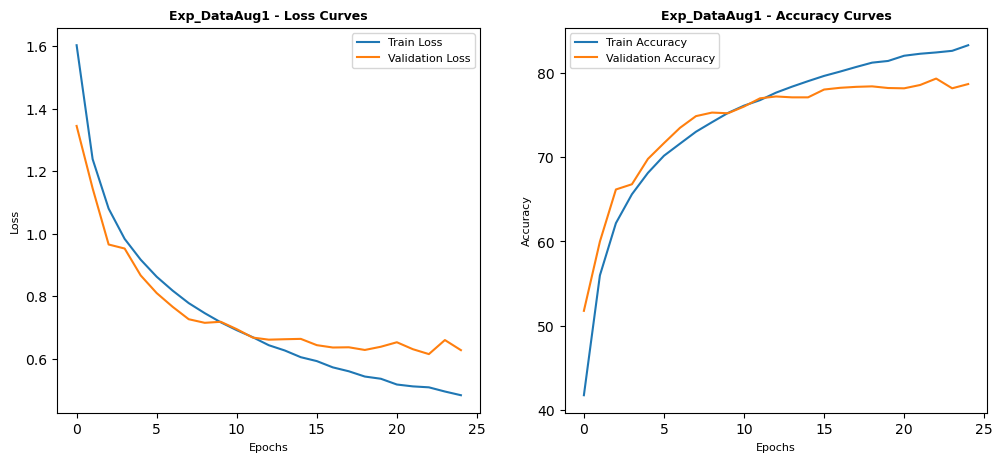

In [6]:
# Print average metrics
print(f"\033[1mAverage Validation Accuracy for the ResNet-18 with dropout = 0.4, weight decay = 0.0001 and Exp_DA1: {np.nanmean(avg_val_acc):.2f}%\033[0m")

# Plot average training/validation loss and accuracy curves
plot_loss_acc(avg_train_loss, avg_val_loss, avg_train_acc, avg_val_acc, title="Exp_DataAug1")

#### 7.2 Experimenting with Random Horizontal Flip and ColorJitter

In [5]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Apply ColorJitter
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# CIFAR-10 dataset with updated transforms
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

# Using the best hyperparameters selected earlier
best_lr = 0.001  
best_batch_size = 32  
best_weight_decay = 0.0001  

print(f"Experimenting with Dropout=0.4 Weight Decay={best_weight_decay} and Data Augmentation technique 2")

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
X = trainset.data  # Images
y = np.array(trainset.targets)  # Labels

all_train_loss = []
all_val_loss = []
all_train_acc = []
all_val_acc = []

# Initialize model 
model = ResNet18(num_classes=10, dropout=0.4)
initial_state = model.state_dict()

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}/{skf.n_splits}")

    # Reset model weights before each fold
    model.load_state_dict(initial_state)
    model.to(device)

    # Get training and validation splits
    train_subset = Subset(trainset, train_idx)
    val_subset = Subset(trainset, val_idx)

    # Data loaders for training and validation
    trainloader = DataLoader(train_subset, batch_size=best_batch_size, shuffle=True)
    valloader = DataLoader(val_subset, batch_size=best_batch_size, shuffle=False)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.NAdam(model.parameters(), lr=best_lr, weight_decay=best_weight_decay)

    # Train the model on this fold with early stopping
    train_loss, val_loss, train_acc, val_acc = train_model(
        model, trainloader, valloader, criterion,
        optimizer, num_epochs=25, early_stopping_patience=3
    )

    # Store metrics for all folds
    all_train_loss.append(train_loss)
    all_val_loss.append(val_loss)
    all_train_acc.append(train_acc)
    all_val_acc.append(val_acc)

# Finding the maximum length among all folds for consistency
max_length = max(max(len(x) for x in all_train_loss), max(len(x) for x in all_val_loss))

# Padding all sequences to have the same length
padded_train_loss = pad_sequences(all_train_loss, max_length)
padded_val_loss = pad_sequences(all_val_loss, max_length)
padded_train_acc = pad_sequences(all_train_acc, max_length)
padded_val_acc = pad_sequences(all_val_acc, max_length)

# Calculating average metrics across all folds, ignoring NaN values
avg_train_loss = np.nanmean(padded_train_loss, axis=0)
avg_val_loss = np.nanmean(padded_val_loss, axis=0)
avg_train_acc = np.nanmean(padded_train_acc, axis=0)
avg_val_acc = np.nanmean(padded_val_acc, axis=0)

Files already downloaded and verified
Experimenting with Dropout=0.4 Weight Decay=0.0001 and Data Augmentation technique 2
Fold 1/3
Epoch [1/25], Train Loss: 1.6488, Val Loss: 1.3663, Train Acc: 40.38%, Val Acc: 51.47%
Epoch [2/25], Train Loss: 1.2764, Val Loss: 1.3292, Train Acc: 55.17%, Val Acc: 53.88%
Epoch [3/25], Train Loss: 1.1182, Val Loss: 1.0030, Train Acc: 61.10%, Val Acc: 63.90%
Epoch [4/25], Train Loss: 1.0185, Val Loss: 1.0949, Train Acc: 64.80%, Val Acc: 63.73%
Epoch [5/25], Train Loss: 0.9541, Val Loss: 0.8745, Train Acc: 66.74%, Val Acc: 69.32%
Epoch [6/25], Train Loss: 0.9017, Val Loss: 0.8838, Train Acc: 68.63%, Val Acc: 68.77%
Epoch [7/25], Train Loss: 0.8617, Val Loss: 0.8125, Train Acc: 70.20%, Val Acc: 71.85%
Epoch [8/25], Train Loss: 0.8202, Val Loss: 0.7911, Train Acc: 71.42%, Val Acc: 72.48%
Epoch [9/25], Train Loss: 0.7908, Val Loss: 0.7735, Train Acc: 72.71%, Val Acc: 72.97%
Epoch [10/25], Train Loss: 0.7558, Val Loss: 0.7443, Train Acc: 73.93%, Val Acc: 74.3

Average Validation Accuracy for the ResNet-18 with dropout = 0.4, weight decay = 0.0001 and Exp_DA2: 73.15%


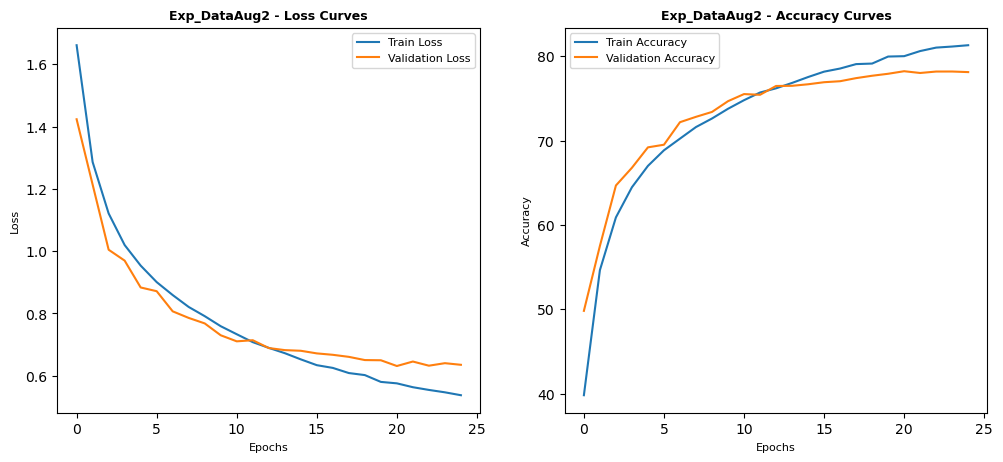

In [6]:
# Print average metrics
print(f"\033[1mAverage Validation Accuracy for the ResNet-18 with dropout = 0.4, weight decay = 0.0001 and Exp_DA2: {np.nanmean(avg_val_acc):.2f}%\033[0m")

# Plot average training/validation loss and accuracy curves
plot_loss_acc(avg_train_loss, avg_val_loss, avg_train_acc, avg_val_acc, title="Exp_DataAug2")

##### Using random horizontal flip technique along with optimal hyperparameters yielded the highest validation score among all experiments so far. Therefore we can consider that model as the best performing ResNet-18 model.

### 8. Experimenting with different network structures

#### 8.1 Experimenting with MobileNetV2

In [39]:
# Configurations
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 25
batch_size = 32

transform_train_mobilenet = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# CIFAR-10 dataset with updated transforms
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train_mobilenet)

print("Training MobileNetV2")

all_train_loss = []
all_val_loss = []
all_train_acc = []
all_val_acc = []

# Initialize model and save initial weights
model = torchvision.models.mobilenet_v2(weights=None, width_mult=0.5)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 10)  
initial_state = model.state_dict()

# Stratified K-Fold Cross-Validation Setup
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
X = trainset.data  # Images
y = np.array(trainset.targets)  # Labels

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}/{skf.n_splits}")

    # Reset model weights before each fold
    model.load_state_dict(initial_state)
    model.to(device)

    # Subsets for training and validation for the current fold
    train_subset = Subset(trainset, train_idx)
    val_subset = Subset(trainset, val_idx)

    # Data loaders for training and validation
    trainloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    valloader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Train the model on this fold with early stopping
    train_loss, val_loss, train_acc, val_acc = train_model(
        model, trainloader, valloader, criterion,
        optimizer, num_epochs=num_epochs, early_stopping_patience=3
    )

    # Store metrics for all folds
    all_train_loss.append(train_loss)
    all_val_loss.append(val_loss)
    all_train_acc.append(train_acc)
    all_val_acc.append(val_acc)

# Find the maximum length among all folds for consistency
max_length = max(max(len(x) for x in all_train_loss), max(len(x) for x in all_val_loss))

# Pad all sequences to have the same length
padded_train_loss = pad_sequences(all_train_loss, max_length)
padded_val_loss = pad_sequences(all_val_loss, max_length)
padded_train_acc = pad_sequences(all_train_acc, max_length)
padded_val_acc = pad_sequences(all_val_acc, max_length)

# Calculate average metrics across all folds, ignoring NaN values
avg_train_loss = np.nanmean(padded_train_loss, axis=0)
avg_val_loss = np.nanmean(padded_val_loss, axis=0)
avg_train_acc = np.nanmean(padded_train_acc, axis=0)
avg_val_acc = np.nanmean(padded_val_acc, axis=0)

Files already downloaded and verified
Training MobileNetV2
Fold 1/3
Epoch [1/25], Train Loss: 2.1140, Val Loss: 1.8665, Train Acc: 22.08%, Val Acc: 29.22%
Epoch [2/25], Train Loss: 1.7874, Val Loss: 1.6528, Train Acc: 33.65%, Val Acc: 38.63%
Epoch [3/25], Train Loss: 1.6577, Val Loss: 1.5455, Train Acc: 39.28%, Val Acc: 43.50%
Epoch [4/25], Train Loss: 1.5635, Val Loss: 1.5194, Train Acc: 42.73%, Val Acc: 45.19%
Epoch [5/25], Train Loss: 1.4980, Val Loss: 1.4460, Train Acc: 45.62%, Val Acc: 46.67%
Epoch [6/25], Train Loss: 1.4394, Val Loss: 1.3783, Train Acc: 47.78%, Val Acc: 50.34%
Epoch [7/25], Train Loss: 1.3721, Val Loss: 1.3212, Train Acc: 50.63%, Val Acc: 53.25%
Epoch [8/25], Train Loss: 1.3172, Val Loss: 1.2405, Train Acc: 53.00%, Val Acc: 55.43%
Epoch [9/25], Train Loss: 1.2509, Val Loss: 1.1956, Train Acc: 55.67%, Val Acc: 57.78%
Epoch [10/25], Train Loss: 1.1947, Val Loss: 1.1256, Train Acc: 58.04%, Val Acc: 59.93%
Epoch [11/25], Train Loss: 1.1387, Val Loss: 1.0889, Train Ac

Average Validation Accuracy Across Folds for MobileNetV2: 59.44%


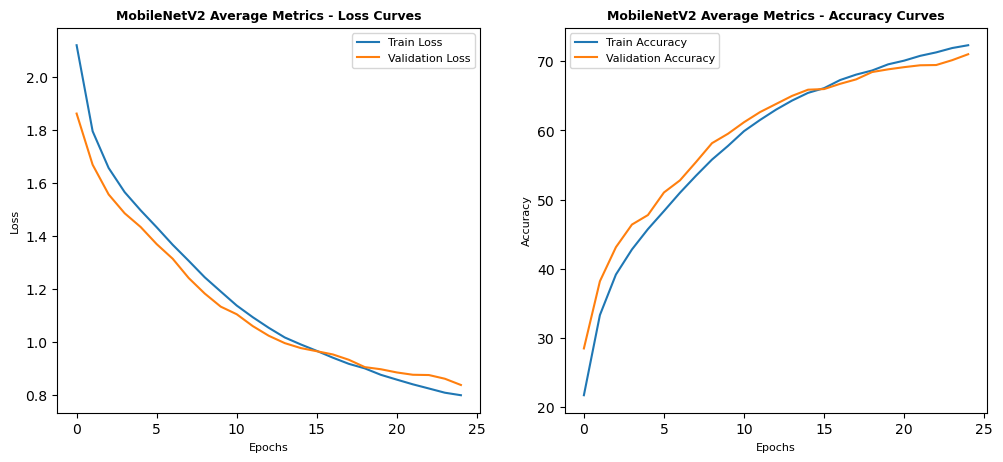

In [40]:
# Print average metrics
print(f"Average Validation Accuracy Across Folds for MobileNetV2: {np.nanmean(avg_val_acc):.2f}%")

# Plot average training/validation loss and accuracy curves
plot_loss_acc(avg_train_loss, avg_val_loss, avg_train_acc, avg_val_acc, title="MobileNetV2 Average Metrics")

#### 8.2 Experimenting with a Moderate CNN 

In [4]:
# Configurations
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 25
batch_size = 32

transform_train_cnn = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# CIFAR-10 dataset with updated transforms
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train_cnn)


class ModerateCNN(nn.Module):
    def __init__(self):
        super(ModerateCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self._to_linear = 64 * 16 * 16
        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        
print("Training Moderate CNN model")

all_train_loss = []
all_val_loss = []
all_train_acc = []
all_val_acc = []

# Initialize model and save initial weights
model = ModerateCNN()
print(model)
initial_state = model.state_dict()

# Stratified K-Fold Cross-Validation Setup
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
X = trainset.data  # Images
y = np.array(trainset.targets)  # Labels

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}/{skf.n_splits}")

    # Reset model weights before each fold
    model.load_state_dict(initial_state)
    model.to(device)

    # Subsets for training and validation for the current fold
    train_subset = Subset(trainset, train_idx)
    val_subset = Subset(trainset, val_idx)

    # Data loaders for training and validation
    trainloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    valloader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Train the model on this fold with early stopping
    train_loss, val_loss, train_acc, val_acc = train_model(
        model, trainloader, valloader, criterion,
        optimizer, num_epochs=num_epochs, early_stopping_patience=3
    )

    # Store metrics for all folds
    all_train_loss.append(train_loss)
    all_val_loss.append(val_loss)
    all_train_acc.append(train_acc)
    all_val_acc.append(val_acc)

# Find the maximum length among all folds for consistency
max_length = max(max(len(x) for x in all_train_loss), max(len(x) for x in all_val_loss))

# Pad all sequences to have the same length
padded_train_loss = pad_sequences(all_train_loss, max_length)
padded_val_loss = pad_sequences(all_val_loss, max_length)
padded_train_acc = pad_sequences(all_train_acc, max_length)
padded_val_acc = pad_sequences(all_val_acc, max_length)

# Calculate average metrics across all folds, ignoring NaN values
avg_train_loss = np.nanmean(padded_train_loss, axis=0)
avg_val_loss = np.nanmean(padded_val_loss, axis=0)
avg_train_acc = np.nanmean(padded_train_acc, axis=0)
avg_val_acc = np.nanmean(padded_val_acc, axis=0)

Files already downloaded and verified
Training Moderate CNN model
ModerateCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
Fold 1/3
Epoch [1/25], Train Loss: 1.3071, Val Loss: 1.0481, Train Acc: 53.19%, Val Acc: 63.27%
Epoch [2/25], Train Loss: 0.9272, Val Loss: 0.9270, Train Acc: 67.19%, Val Acc: 67.43%
Epoch [3/25], Train Loss: 0.7955, Val Loss: 0.9349, Train Acc: 72.23%, Val Acc: 67.66%
Epoch [4/25], Train Loss: 0.6901, Val Loss: 0.9076, Train Acc: 76.17%, Val Acc: 69.00%
Epoch [5/25], Train Loss: 0.5932, Val Loss: 0.9372, Train Acc: 79.51%, Val Acc: 69.05%
Epoch [6/25], Train Loss: 0.5120, Val Loss: 0.9489, Train Acc: 82.25%, Val Acc: 69.06%
Epoch [7/25], Train Loss:

Average Validation Accuracy Across Folds for Moderate CNN : 67.88%


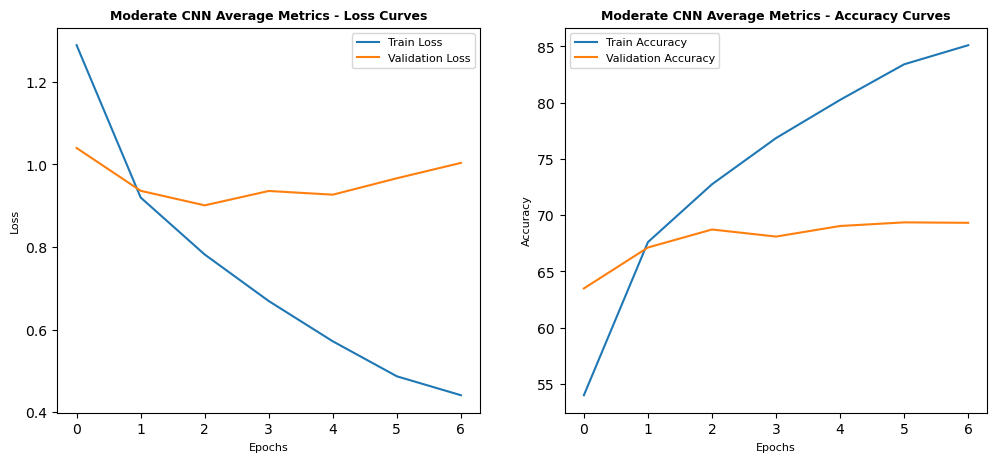

In [5]:
# Print average metrics
print(f"Average Validation Accuracy Across Folds for Moderate CNN : {np.nanmean(avg_val_acc):.2f}%")

# Plot average training/validation loss and accuracy curves
plot_loss_acc(avg_train_loss, avg_val_loss, avg_train_acc, avg_val_acc, title="Moderate CNN Average Metrics")

##### Using random horizontal flip data augmentation technique along with optimal hyperparameters and dropout of 0.4 on ResNet-18, can be selected as the best model based on the cross validation performance.

### 9. Final Model training and evaluation

#### 9.1 Final model retraining on full training dataset

In [4]:
# Custom ResNet-18 from scratch with Dropout
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout=0.4):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=dropout)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)
        return out


class ResNet18(nn.Module):
    def __init__(self, num_classes=10, dropout=0.4):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 2, dropout=dropout)
        self.layer2 = self._make_layer(128, 2, stride=2, dropout=dropout)
        self.layer3 = self._make_layer(256, 2, stride=2, dropout=dropout)
        self.layer4 = self._make_layer(512, 2, stride=2, dropout=dropout)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride=1, dropout=0.4):
        layers = []
        layers.append(BasicBlock(self.in_channels, out_channels, stride, dropout))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels, dropout=dropout))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [5]:
print("Retraining the final model on the entire training set")

# Data Augmentation and Normalization for Training Data
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# CIFAR-10 dataset with updated transforms for training
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

# Initialize ResNet-18 model and move to device
final_model = ResNet18(num_classes=10, dropout=0.4)
final_model = final_model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.NAdam(final_model.parameters(), lr=0.001, weight_decay=0.0001)  # Optimal Learning rate and weight decay

# Train the model using the full training set (without validation)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)

# Reuse the train_model function without validation
train_loss, _, train_acc, _ = train_model(
    final_model, trainloader, None, criterion, optimizer, num_epochs=200, early_stopping_patience=3
)

Retraining the final model on the entire training set
Files already downloaded and verified
Epoch [1/200], Train Loss: 1.5095, Train Acc: 45.50%
Epoch [2/200], Train Loss: 1.1277, Train Acc: 60.51%
Epoch [3/200], Train Loss: 0.9784, Train Acc: 65.92%
Epoch [4/200], Train Loss: 0.8950, Train Acc: 68.79%
Epoch [5/200], Train Loss: 0.8361, Train Acc: 71.13%
Epoch [6/200], Train Loss: 0.7904, Train Acc: 72.71%
Epoch [7/200], Train Loss: 0.7453, Train Acc: 74.39%
Epoch [8/200], Train Loss: 0.7131, Train Acc: 75.63%
Epoch [9/200], Train Loss: 0.6836, Train Acc: 76.44%
Epoch [10/200], Train Loss: 0.6638, Train Acc: 77.12%
Epoch [11/200], Train Loss: 0.6424, Train Acc: 77.97%
Epoch [12/200], Train Loss: 0.6274, Train Acc: 78.51%
Epoch [13/200], Train Loss: 0.6061, Train Acc: 79.18%
Epoch [14/200], Train Loss: 0.5903, Train Acc: 79.71%
Epoch [15/200], Train Loss: 0.5818, Train Acc: 79.94%
Epoch [16/200], Train Loss: 0.5664, Train Acc: 80.33%
Epoch [17/200], Train Loss: 0.5548, Train Acc: 80.82%

#### 9.2 Final model evaluation on test set

In [6]:
# Load the test data loader
testloader = DataLoader(testset, batch_size=32, shuffle=False)

# Evaluate the final model on the test set
test_model(final_model, testloader, "Final model")

Final model - Test Accuracy: 81.91%
